# Yelp Dataset Exploritory Data Analysis

## Business Dataset
Looking at the business dataset, I begin with the following questions:
- [How many businesses are there in Las Vegas](#numRestaurants)
- [Opening/Closing times](#openClose)
- [Basic stats about the stars](#starData)
 - STD
 - Mean
 - Mode
 - Median
- [Attributes](#attributes)
- [Closed Businesses](#closed)
- Is there a correlation between stars and price-range


In [3]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import json
import re
from scipy import stats
import pygal
import seaborn as sns
import pickle

In [2]:
def make_pie(labels, count, explode_label='',t=''):
    
    explode = np.zeros(len(labels))

    if explode_label != '':
        explode_index = labels.index(explode_label)
        explode[explode_index] = 0.1

    # Plot
    fig1, ax1 = plt.subplots()
    ax1.pie(count, explode=explode, labels=labels,
            autopct='%1.1f%%', shadow=True, startangle=140, colors=['#A9A9A9','gray'])
    plt.title(t)
    plt.axis('equal')
    plt.show()
    
    
def dict_to_pies(d_true, d_false):
    for key in d_true.keys():
        if key not in d_false.keys():
            # need key in both true and false otherwise results won't make sense
            continue
        if isinstance(d_true[key],dict):
            dict_to_pies(d_true[key], d_false[key])
        else:
            labels = ['True','False']
            values = [d_true[key],d_false[key]]
            make_pie(labels, values, t=key)
        
    
def make_bar(labels, count, t="", yl="", xl=""):
    y_pos = np.arange(len(labels))

    plt.bar(y_pos, count, align='center', alpha=0.5)
    plt.xticks(y_pos, labels)
    plt.ylabel(yl)
    plt.xlabel(xl)
    plt.title(t)

    plt.show()

<a id="numRestaurants"></a>
## Number of Restaurants in Las Vegas

In [3]:
# load in the file
business_file = 'D:\\home\\mhanl\\data_mining\\project\\yelp_dataset\\csv\\cities\\business_las_vegas.csv'
business_data = pd.read_csv(business_file)

# strip the entries that don't have anything in the categories subset.
business_data_clean_categories = business_data.dropna(subset=['categories'])

# grab all the frames with "Restaurants" category
restaurant_df = business_data_clean_categories[business_data_clean_categories['categories'].str.contains('Restaurants')]

nRestaurants = restaurant_df.shape[0]
print("There are %d restaurants in the file." % nRestaurants)

There are 6151 restaurants in the file.


<a id="openClose"></a>
## Opening and Closing Times

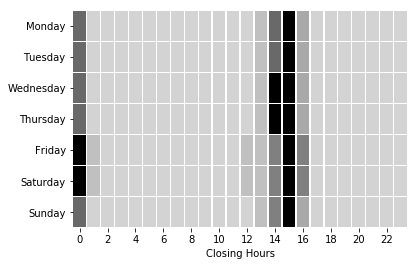

In [4]:
hours = restaurant_df['hours']
hours = hours.dropna()
hours_dict_open = {'Monday':{},'Tuesday':{},'Wednesday':{},'Thursday':{},'Friday':{},'Saturday':{},'Sunday':{}}
hours_dict_close = {'Monday':{},'Tuesday':{},'Wednesday':{},'Thursday':{},'Friday':{},'Saturday':{},'Sunday':{}}

for row in hours:
    json_hours = row.replace("'", "\"")
    d = json.loads(json_hours)
    
    for key in d:
        times = d[key].split('-')
        _open = times[0].split(':')[0]
        _close = times[1].split(':')[0]
        
        if _open in hours_dict_open[key]:
            hours_dict_open[key][_open] += 1
        else:
            hours_dict_open[key][_open] = 1
            
        if _close in hours_dict_close[key]:
            hours_dict_close[key][_close] += 1
        else:
            hours_dict_close[key][_close] = 1



data_open = np.empty([7,24])
data_close = np.empty([7,24])

hours_dict_open['Monday']['2'] = 0
hours_dict_open['Tuesday']['2'] = 0
hours_dict_open['Wednesday']['2'] = 0
hours_dict_open['Friday']['2'] = 0
hours_dict_open['Saturday']['2'] = 0
hours_dict_open['Sunday']['2'] = 0
hours_dict_open['Sunday']['21'] = 0

# print(hours_dict_open)
for i, key in enumerate(hours_dict_close):
    keys_sorted_open = list(hours_dict_open[key].keys())
    keys_sorted_open.sort(key=int)
#     print(keys_sorted_open)
    values_sorted_open = [x for _,x in sorted(zip(list(hours_dict_open[key].keys()),list(hours_dict_open[key].values())))]
    data_open[i,:] = values_sorted_open
    
    keys_sorted_close = list(hours_dict_close[key].keys())
    keys_sorted_close.sort(key=int)
    values_sorted_close = [x for _,x in sorted(zip(list(hours_dict_close[key].keys()),list(hours_dict_close[key].values())))]
    data_close[i,:] = values_sorted_close

    
days = ['Sunday Open',   'Sunday Close',
        'Monday Open',   'Monday Close',
        'Tuesday Open',  'Tuesday Close',
        'Wednesday Open','Wednesday Close',
        'Thursday Open', 'Thursday Close',
        'Friday Open',   'Friday Close',
        'Saturday Open', 'Saturday Close']
pyramid = pygal.Pyramid(human_readable=True, legend_at_bottom=True)
pyramid.title = 'Business Opening and Closing Times'
pyramid.x_labels = map(lambda x: str(x) if not x % 2 else '', range(1,24))

# for day, hour in zip(days, hourss):
# #     print(day)
# #     print(hour)
#     pyramid.add(day,hour)
# ax = sns.heatmap(data_open, xticklabels=2, yticklabels=False)
flatui = ["#000000", "#696969", "#808080", "#A9A9A9", "#C0C0C0", "#D3D3D3"]
# sns.palplot(sns.color_palette(flatui))
ax2 = sns.heatmap(data_close, xticklabels=2, 
                  yticklabels=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
                  cmap=sns.color_palette(flatui[::-1]),
                 linewidths=0.5,
                 square=False,
                 cbar=False)
ax2.set_xlabel('Closing Hours')
# ax2.title = "Closing Times"

pyramid.render_to_file('pyramid.svg')

<a id="starData"></a>
## Star Data

Average:            3.476752
Standard Deviation: 0.808846
Mode:               4.000000
Median:             3.500000


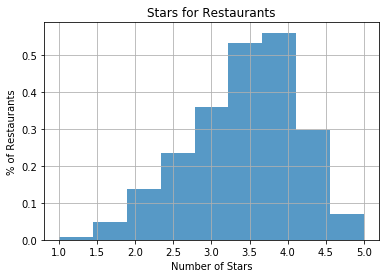

In [5]:
stars = restaurant_df['stars'].values
print("Average:            %f" % stars.mean())
print("Standard Deviation: %f"% stars.std())
print("Mode:               %f" % stats.mode(stars)[0][0])
print("Median:             %f" % np.median(stars))

plt.hist(stars, bins=9,density=1,alpha=0.75)
plt.ylabel('% of Restaurants')
plt.xlabel("Number of Stars")
plt.title("Stars for Restaurants")
plt.grid(True)
plt.show()

<a id="attributes"></a>
## Attributes
This section compiles the attributes into two dictionaries. `att_dict` contains all the "True" counts aggregated on the attribute types. `att_dict_compliment` holds all the false counts. `att_dict_compliment` is needed because sometimes restaurants don't have 'True' or 'False' listed for a specific attribute, and assuming it to be 'False' would be incorrect.

{'AcceptsInsurance': 2,
 'AgesAllowed': {'21plus': 14, 'allages': 1},
 'Alcohol': {'beer_and_wine': 821, 'full_bar': 1738, 'none': 2632},
 'Ambience': {'casual': 3100,
              'classy': 214,
              'divey': 144,
              'hipster': 89,
              'intimate': 73,
              'romantic': 90,
              'touristy': 108,
              'trendy': 379,
              'upscale': 108},
 'BYOB': 14,
 'BYOBCorkage': {'no': 123, 'yes_corkage': 68, 'yes_free': 137},
 'BestNights': {'friday': 413,
                'monday': 70,
                'saturday': 440,
                'sunday': 182,
                'thursday': 190,
                'tuesday': 64,
                'wednesday': 88},
 'BikeParking': 3029,
 'BusinessAcceptsBitcoin': 14,
 'BusinessAcceptsCreditCards': 5841,
 'BusinessParking': {'garage': 881,
                     'lot': 2811,
                     'street': 321,
                     'valet': 403,
                     'validated': 31},
 'ByAppointmentOnly': 11

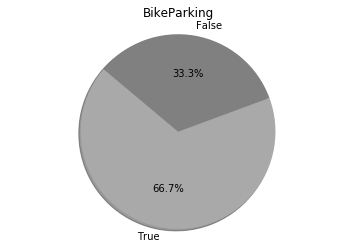

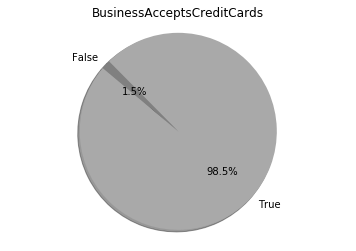

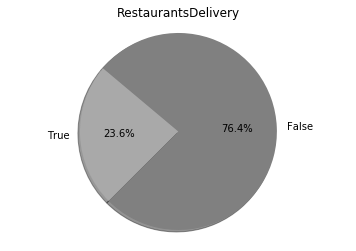

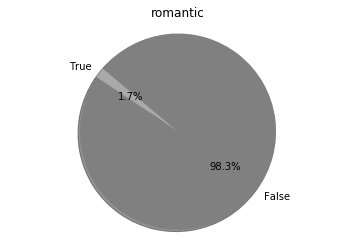

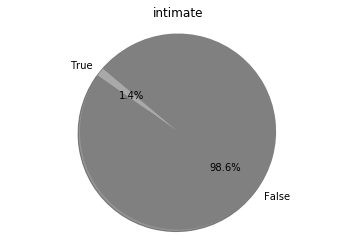

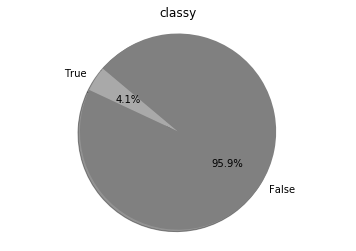

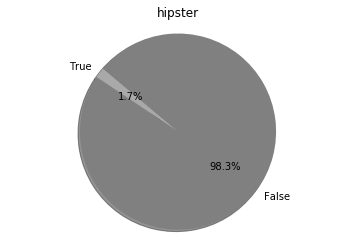

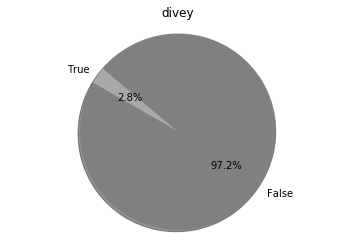

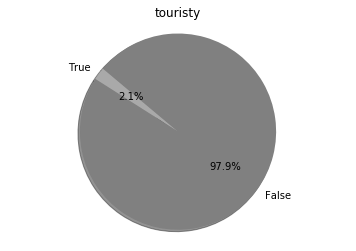

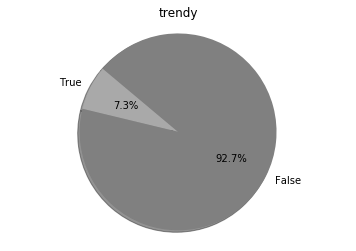

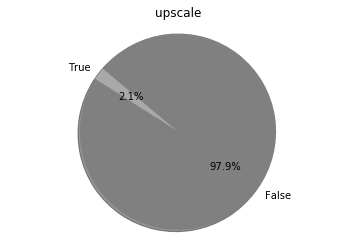

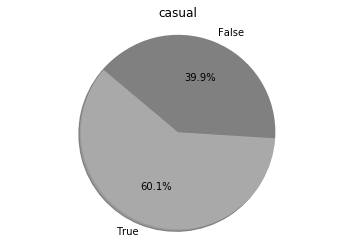

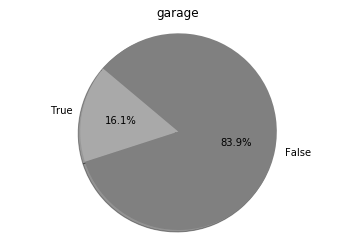

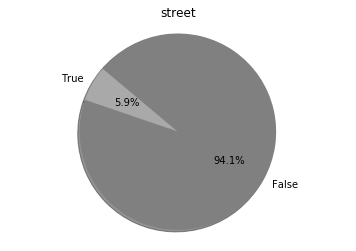

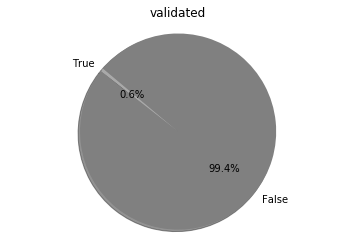

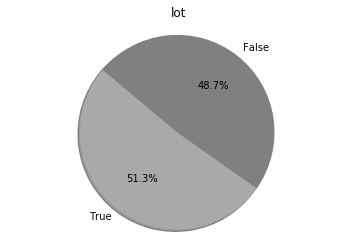

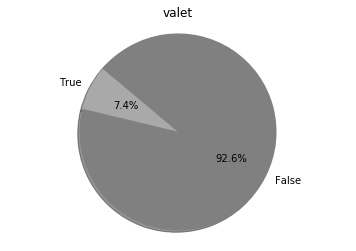

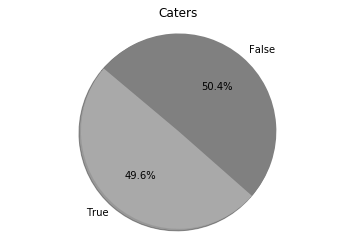

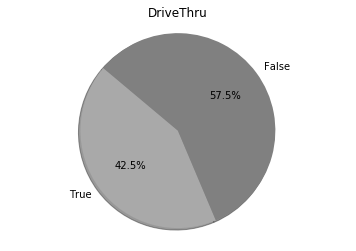

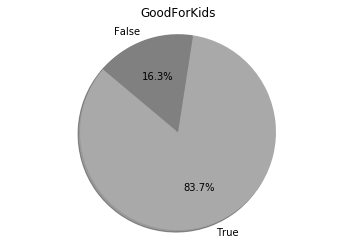

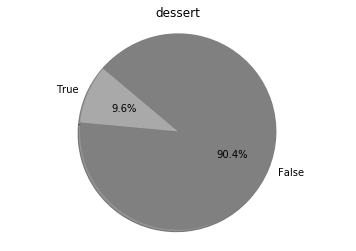

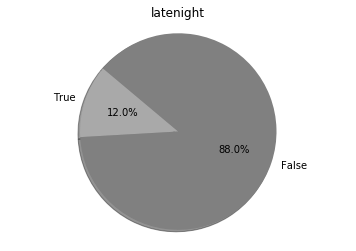

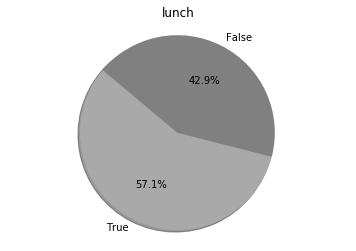

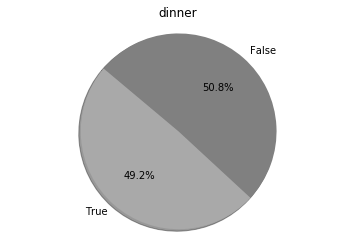

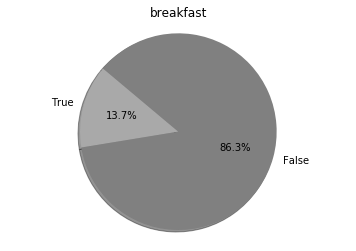

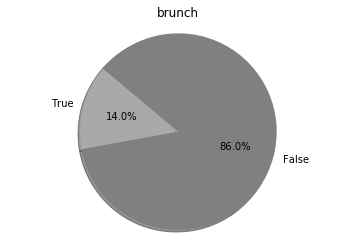

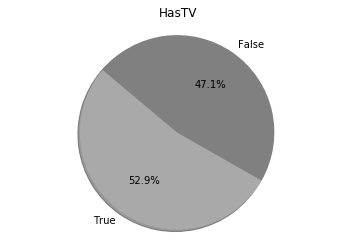

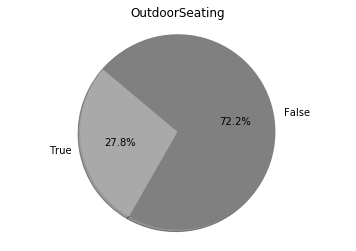

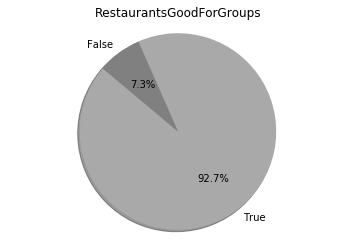

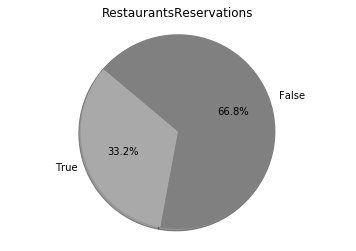

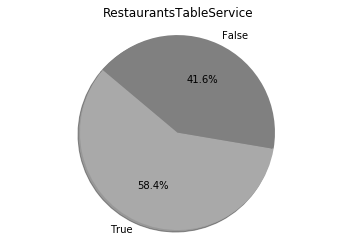

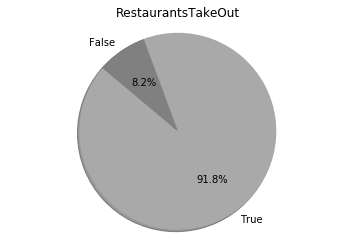

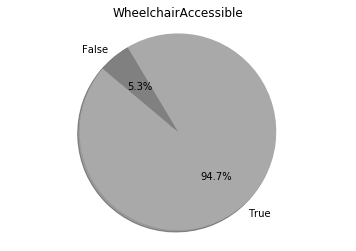

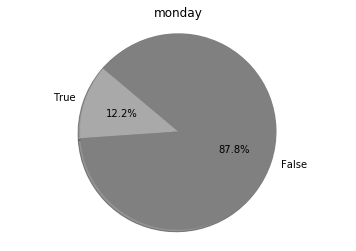

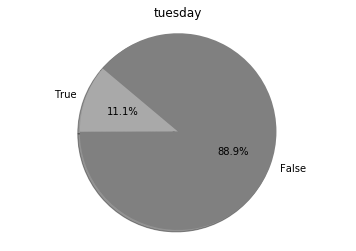

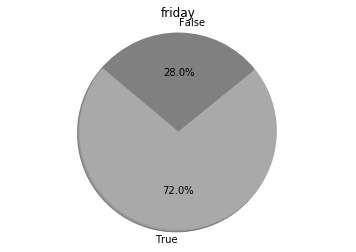

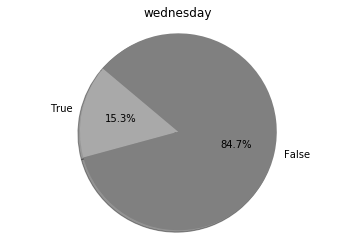

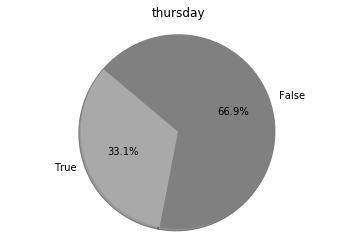

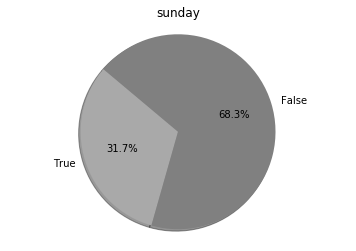

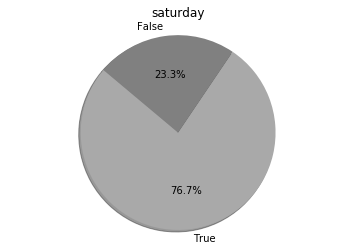

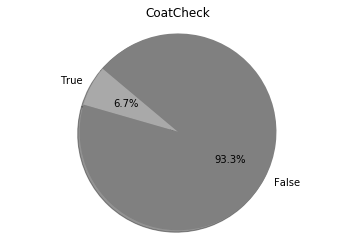

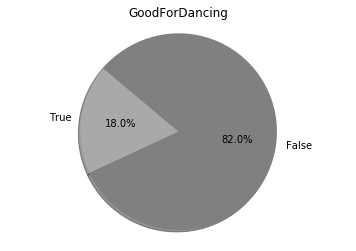

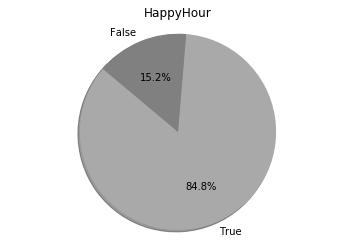

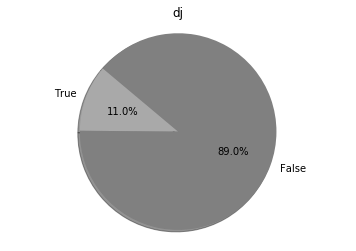

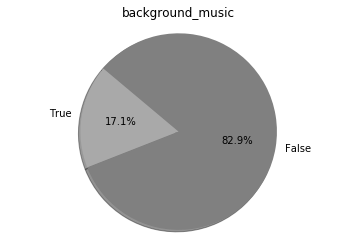

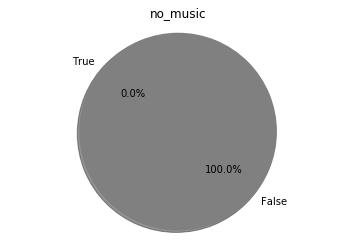

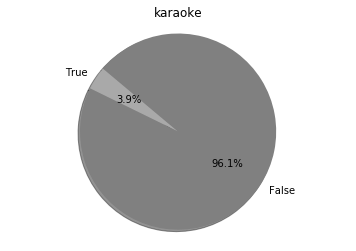

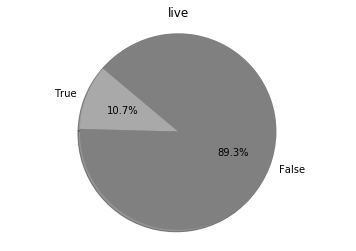

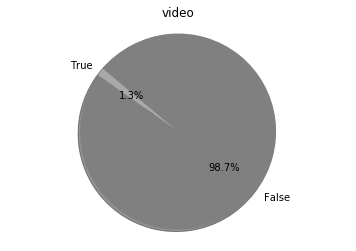

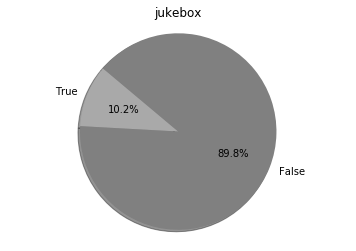

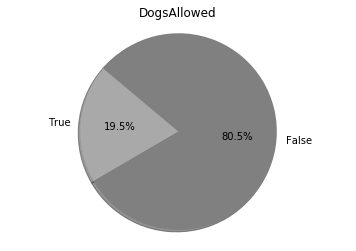

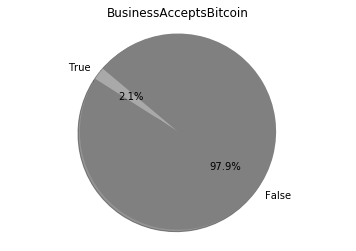

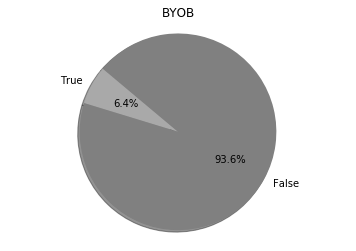

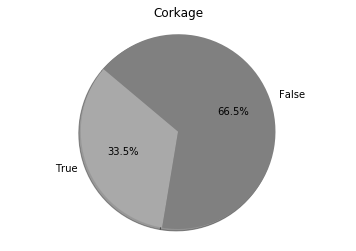

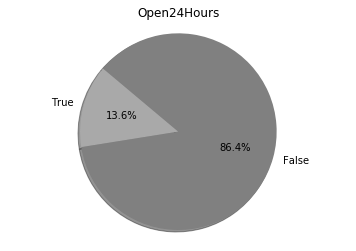

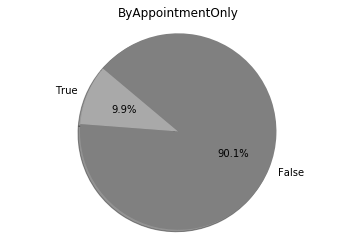

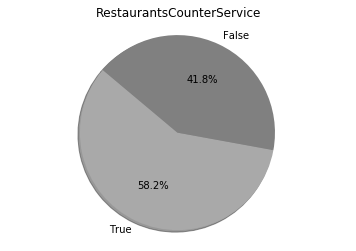

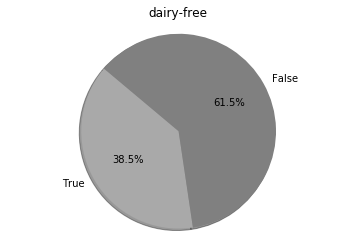

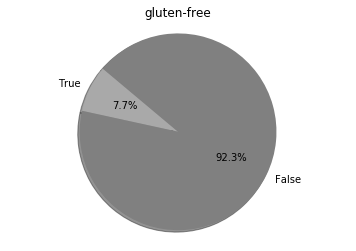

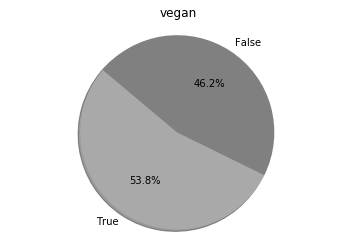

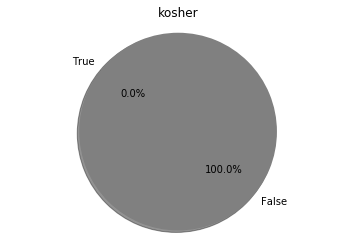

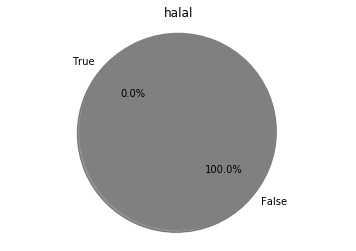

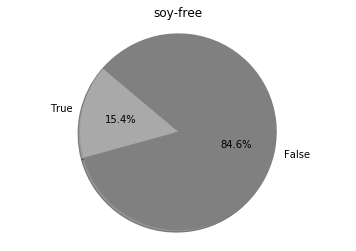

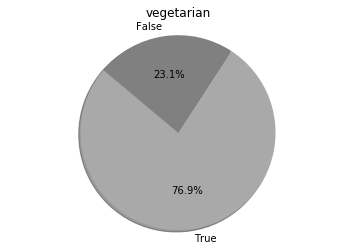

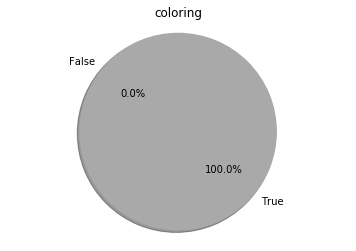

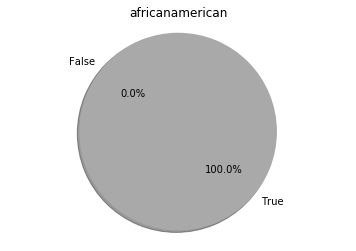

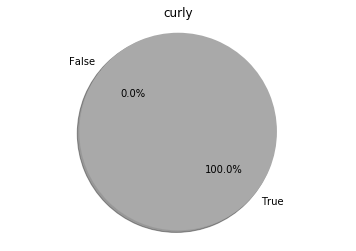

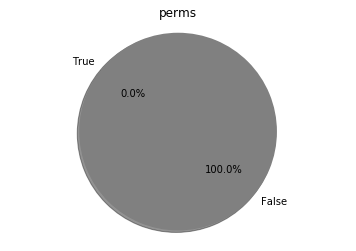

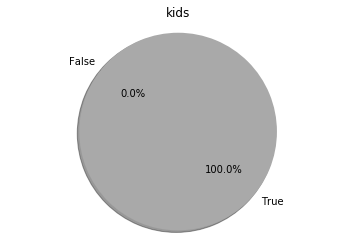

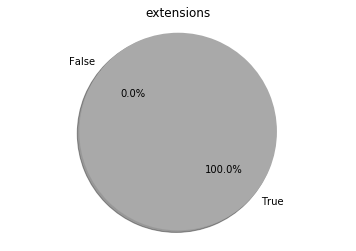

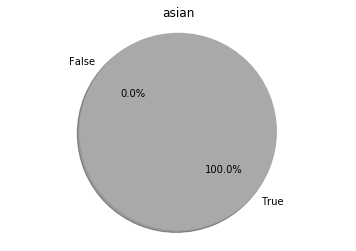

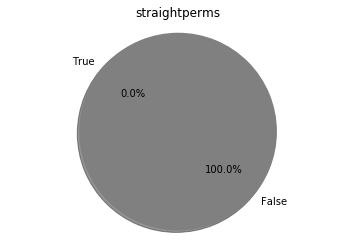

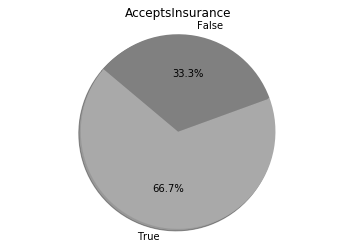

In [6]:
attributes = restaurant_df['attributes']
attributes = attributes.dropna()
att_dict = {}
att_dict_compliment = {}

for att in attributes:
    try:
        json_attributes = att.replace("'", "\"")
    except AttributeError as e:
        print(att)
        raise e
    json_attributes = json_attributes.replace(': True',': "True"')
    json_attributes = json_attributes.replace(': False',': \"False\"')
    json_attributes = json_attributes.replace('"{','{')
    json_attributes = json_attributes.replace('}"','}')

    d=json.loads(json_attributes)
    for key in d:
        if isinstance(d[key],dict):
            if key not in att_dict.keys():
                att_dict[key] = {}
                att_dict_compliment[key] = {}
            for subkey in d[key]:
                if d[key][subkey] == 'True':
                    add_num = 1
                    add_num_compliment = 0
                elif d[key][subkey] == 'False':
                    add_num = 0
                    add_num_compliment = 1
                else:
                    raise KeyError
                if subkey in att_dict[key].keys():
                    att_dict[key][subkey] += add_num
                    att_dict_compliment[key][subkey] += add_num_compliment
                else:
                    att_dict[key][subkey] = add_num
                    att_dict_compliment[key][subkey] = add_num_compliment
        else:
            add_num = -1
            if d[key] == 'True':
                add_num = 1
                add_num_compliment = 0
            elif d[key] == 'False':
                add_num = 0
                add_num_compliment = 1
            else:
                add_num = d[key]
                            
            if type(add_num) == str:
                if key not in att_dict.keys():
                    att_dict[key] = {}
                if add_num in att_dict[key].keys():
                    att_dict[key][add_num] += 1
                else:
                    att_dict[key][add_num] = 1
            else:
                if key not in att_dict.keys():
                    att_dict[key] = add_num
                    att_dict_compliment[key] = add_num_compliment
                else:
                    att_dict[key] += add_num
                    att_dict_compliment[key] += add_num_compliment

# ======== UNCOMMENT TO PRINT THE ACTUAL NUMBERS ==============================
pprint(att_dict)                   
pprint(att_dict_compliment)

# ======== UNCOMMENT TO SEE BINARY PIE CHARTS =================================
dict_to_pies(att_dict, att_dict_compliment)
        

# ambience_labels = att_dict['Ambience'].keys()
# ambience_counts_true = att_dict['Ambience'].values()    
# ambience_counts_false = att_dict_compliment['Ambience'].values()


# make_pie(ambience_labels, ambience_counts_true,t='Ambience True Counts')
# make_pie(ambience_labels, ambience_counts_false,t='Ambience False Counts')

<a id="closed"></a>
## Businesses Open vs. Closed
Finding the number of businesses that are still open.

percent closed: 33.978215


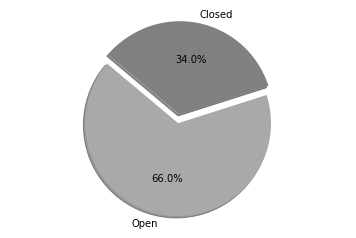

In [7]:
is_open = restaurant_df[['is_open','stars','review_count']].values
num = len(is_open[:,0])
closed = num - np.count_nonzero(is_open[:,0])
print("percent closed: %f" % (closed/num*100))
make_pie(['Open','Closed'],[num-closed,closed],explode_label='Closed')

In [8]:
average_closed = is_open[:,1][np.where(is_open[:,0] == 0)].mean()
average_review_ct_closed = is_open[:,2][np.where(is_open[:,0] == 0)].mean()

print("Average stars for closed restaurants: %f" % average_closed)
print("Average review count for closed restaurants: %f" % average_review_ct_closed)


average_open = is_open[:,1][np.where(is_open[:,0] == 1)].mean()
average_review_ct_open = is_open[:,2][np.where(is_open[:,0] == 1)].mean()

print("\nAverage stars for open restaurants: %f" % average_open)
print("Average review count for open restaurants: %f" % average_review_ct_open)


Average stars for closed restaurants: 3.498565
Average review count for closed restaurants: 79.358852

Average stars for open restaurants: 3.465526
Average review count for open restaurants: 218.552573


In [9]:
restaurant_df

,Unnamed: 0,stars,attributes.BYOBCorkage,postal_code,hours.Saturday,attributes.RestaurantsDelivery,attributes.RestaurantsTakeOut,attributes,attributes.GoodForDancing,attributes.WheelchairAccessible,...,attributes.HasTV,categories,name,attributes.DogsAllowed,attributes.Alcohol,review_count,hours.Friday,attributes.Caters,attributes.BYOB,attributes.BestNights
2,19,1.5,NaN,89106.0,11:0-17:0,False,NaN,"{'BikeParking': 'True', 'BusinessAcceptsCredit...",NaN,NaN,...,NaN,"American (Traditional), Food, Bakeries, Restau...",CakesbyToi,NaN,NaN,3,11:0-18:0,NaN,NaN,NaN
4,32,2.5,NaN,89128.0,9:0-21:0,False,True,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",NaN,NaN,...,False,"Fast Food, Restaurants, Sandwiches",Subway,NaN,none,13,9:0-21:0,True,NaN,NaN
5,33,4.0,NaN,89128.0,7:0-14:30,False,True,"{'Alcohol': 'beer_and_wine', 'Ambience': ""{'ro...",NaN,True,...,True,"Beer, Wine & Spirits, Italian, Food, American ...",Omelet House Summerlin,NaN,beer_and_wine,242,7:0-19:0,False,NaN,NaN
11,61,2.0,NaN,89149.0,NaN,NaN,NaN,"{'HasTV': 'False', 'RestaurantsReservations': ...",NaN,NaN,...,False,"Mexican, Restaurants",Baja Fresh Mexican Grill,NaN,NaN,4,NaN,NaN,NaN,NaN
17,141,1.5,NaN,89110.0,10:0-23:0,False,True,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",NaN,False,...,False,"Chicken Wings, Restaurants, Fast Food",Popeyes Louisiana Kitchen,NaN,none,16,10:0-23:0,False,NaN,NaN
18,143,2.5,NaN,89110.0,10:0-0:0,True,True,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",NaN,False,...,False,"Restaurants, Pizza",Pizza Hut,NaN,none,19,11:0-0:0,False,NaN,NaN
19,145,4.5,NaN,89169.0,NaN,False,True,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...",NaN,NaN,...,NaN,"Japanese, Restaurants",Sansei Japan,NaN,NaN,3,NaN,NaN,NaN,NaN
27,197,3.0,NaN,89121.0,10:0-23:0,False,True,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",NaN,True,...,False,"Restaurants, Salad, Fast Food, Mexican",El Pollo Loco,NaN,none,34,10:0-23:0,True,NaN,NaN
28,203,2.0,NaN,89119.0,10:0-23:0,False,True,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",NaN,NaN,...,False,"Southern, Chicken Wings, Fast Food, American (...",Popeyes Louisiana Kitchen,NaN,none,56,10:0-23:0,False,NaN,NaN
37,249,3.5,NaN,89117.0,0:0-0:0,False,True,"{'Alcohol': 'full_bar', 'Ambience': ""{'romanti...",NaN,True,...,True,"American (New), Restaurants, Food, Breweries, ...",Chicago Brewing Company,NaN,full_bar,446,0:0-0:0,False,NaN,NaN


## Company Age

In [7]:
p = open('time_from_open.pickle', 'rb')
a = pickle.load(p)
weeks = [int(x) for x in a.keys()]
num_reviews = [int(x) for x in a.values()]
num_reviews = [x for _,x in sorted(zip(weeks, num_reviews))]
weeks = sorted(weeks)
chart = pygal.Bar()
chart.title = "Number of Restraunts with Y reviews X weeks from opening"
chart.x_labels = map(str, range(0, len(weeks)))
chart.y_labels = 'Number of Restaurants'
chart.add('', num_reviews)
chart.render_to_file('chart.svg')